# DQN Training
Training a DQN agent using custom gym environment and keras-rl2.

# Imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from gym import Env
from gym.spaces import Discrete, Box

from rl.agents import DQNAgent
from rl.policy import MaxBoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

## Functions

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

# Environment

## Loading Shape Class

In [4]:
import sys  
sys.path.insert(0, "E:\Projects\Python\TetrisRoyaleRL")

from settings import *
from game_env.shapes import Shape

## Reworking the Environment

In [14]:
class GameEnv(Env):
    def __init__(self):
        # spaces
        self.action_space = Discrete(5)
        self.observation_space = Box(low=0.0, high=1.0, shape=(20, 10, 3))
        
        # state
        self.game_over = None

        # coord
        self.map = None

        # shape
        self.shape = None
        self.next_shape = None

        # init env
        self._state_gen()

    def _state_gen(self):
        self.game_over = False
        
        self.map = np.ones((GAME_SHAPE_TOP_HIDDEN + 20 + GAME_SHAPE_BORDERS,
                            GAME_SHAPE_BORDERS + 10 + GAME_SHAPE_BORDERS), dtype=np.int32)
        self.map[0: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0
        
        self.shape = Shape()
        self.next_shape = Shape()

    def _state_observe(self):
        # observable map
        temp_map = self.map[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS].copy()
        
        # observation of cur shape on map
        temp_shape = np.zeros(self.map.shape)
        x0 = self.shape.x
        y0 = int(self.shape.y)
        this_shape = self.shape.get_shape()
        temp_shape[y0: y0 + this_shape.shape[0], x0: x0 + this_shape.shape[1]] += this_shape
        temp_shape = temp_shape[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        
        # next shape on map, assuming y0 = 0
        temp_next_shape = np.zeros((20, 10))
        x0 = self.next_shape.x
        next_shape = self.next_shape.get_shape()
        temp_next_shape[0: next_shape.shape[0], x0: x0 + next_shape.shape[1]] += next_shape

        return np.stack([temp_map, temp_shape, temp_next_shape], axis=-1).astype(np.float32)

    def render(self):
        pass
    
    def reset(self):
        # restart state
        self._state_gen()
        # not terminal
        return self._state_observe()

    def step(self, action):
        reward = 0.001
        # 0 is skip - REMOVED
        # 1 is left
        if action == 1:
            if self.can_move(self.shape.x - 1, int(self.shape.y), self.shape.get_shape()):
                self.shape.x -= 1
            else:
                #reward -= 1
                pass
        # 2 is right
        elif action == 2:
            if self.can_move(self.shape.x + 1, int(self.shape.y), self.shape.get_shape()):
                self.shape.x += 1
            else:
                #reward -= 1
                pass
        # 3 is down
        elif action == 3:
            if self.can_move(self.shape.x, int(self.shape.y + 1), self.shape.get_shape()):
                self.shape.y += 1
            else:
                #reward -= 1
                pass
        # 4 is rotate
        elif action == 4:
            if self.can_move(self.shape.x, int(self.shape.y), self.shape.get_rotated()):
                self.shape.rotate()
            else:
                #reward -= 1
                pass
        # move down
        if self.can_move(self.shape.x, int(self.shape.y + FALL_SPEED), self.shape.get_shape()):
            self.shape.y += FALL_SPEED
        else:
            self.lock_figure()

            #reward for height of locked shapes
            height = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
            height = np.where(height.sum(axis=1) == 0)[0]
            reward += (height.size) / 5
        
        # reward for cleared rows
        reward += self.remove_full_rows()
        
        return self._state_observe(), reward, self.game_over, {}


    def at(self, x, y):
        return self.map[GAME_SHAPE_TOP_HIDDEN + y, GAME_SHAPE_BORDERS + x]

    def can_move(self, x0, y0, figure):
        temp = self.map.copy()
        temp[int(y0): int(y0 + figure.shape[0]), x0: x0 + figure.shape[1]] += figure
        if 2 in temp:
            return False
        else:
            return True

    def lock_figure(self):
        x = self.shape.x
        y = int(self.shape.y)
        figure = self.shape.get_shape()
        self.map[y: y + figure.shape[0], x: x + figure.shape[1]] += figure
        self.shape = self.next_shape
        self.next_shape = Shape()
        if y < GAME_SHAPE_TOP_HIDDEN:
            self.game_over = True


    def remove_full_rows(self):
        reward = 0
        full = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        full = np.where(full.sum(axis=1) == 10)[0]
        if full.size > 0:
            reward = full.size * 10

            # to get indexes of the game screen
            full = full + GAME_SHAPE_TOP_HIDDEN

            # remove full rows
            self.map[full, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0

            # get non-empty rows
            partial = self.map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
            partial = np.where(partial.sum(axis=1) != 0)[0]

            # if there are levitating non-empty rows
            if partial.size > 0:
                # get their indexes
                partial = partial + GAME_SHAPE_TOP_HIDDEN
                bottom = self.map.shape[0] - GAME_SHAPE_BORDERS
                # move them to bottom
                self.map[bottom-partial.size: bottom, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = \
                    self.map[partial, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
                # everything above must be cleared
                self.map[0: bottom-partial.size, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] = 0
        return reward

## Create env

In [15]:
env = GameEnv()

## Test Random

In [16]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = np.random.randint(0, 5)
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 37.9899999999998, Steps: 990
Episode: 2, Score: 23.732000000000202, Steps: 532
Episode: 3, Score: 42.37799999999962, Steps: 978
Episode: 4, Score: 38.56299999999984, Steps: 963
Episode: 5, Score: 24.434000000000303, Steps: 834
Episode: 6, Score: 40.76999999999973, Steps: 970
Episode: 7, Score: 41.57099999999967, Steps: 971
Episode: 8, Score: 39.281999999999805, Steps: 882
Episode: 9, Score: 35.61400000000017, Steps: 814
Episode: 10, Score: 29.766000000000425, Steps: 766
Episode: 11, Score: 40.70199999999976, Steps: 902
Episode: 12, Score: 35.42700000000013, Steps: 827
Episode: 13, Score: 34.69000000000008, Steps: 890
Episode: 14, Score: 38.973999999999634, Steps: 974
Episode: 15, Score: 49.50099999999972, Steps: 901
Episode: 16, Score: 39.29599999999991, Steps: 896
Episode: 17, Score: 44.168999999999585, Steps: 969
Episode: 18, Score: 44.70399999999946, Steps: 1104
Episode: 19, Score: 41.30999999999963, Steps: 910
Episode: 20, Score: 33.0010000000004, Steps: 801
Epis

## Test do-nothing

In [17]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = 0
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 20.34300000000016, Steps: 943
Episode: 2, Score: 21.61000000000024, Steps: 1010
Episode: 3, Score: 19.92500000000015, Steps: 925
Episode: 4, Score: 20.131000000000146, Steps: 931
Episode: 5, Score: 21.99800000000017, Steps: 998
Episode: 6, Score: 22.226000000000205, Steps: 1026
Episode: 7, Score: 19.931000000000157, Steps: 931
Episode: 8, Score: 19.305000000000135, Steps: 905
Episode: 9, Score: 22.851000000000237, Steps: 1051
Episode: 10, Score: 22.846000000000412, Steps: 1046
Episode: 11, Score: 21.81800000000022, Steps: 1018
Episode: 12, Score: 20.752000000000145, Steps: 952
Episode: 13, Score: 20.545000000000147, Steps: 945
Episode: 14, Score: 21.171000000000177, Steps: 971
Episode: 15, Score: 20.137000000000175, Steps: 937
Episode: 16, Score: 22.230000000000253, Steps: 1030
Episode: 17, Score: 29.93200000000072, Steps: 1332
Episode: 18, Score: 20.96400000000017, Steps: 964
Episode: 19, Score: 18.870000000000093, Steps: 870
Episode: 20, Score: 20.752000000000145, 

# Nural Network and Agent

## Build model

In [18]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
def build_model():
    return tf.keras.Sequential([
    # 1 state, 20 rows, 10 cols, 3 matricies: locked, falling and next figures
    layers.Input(shape=(1, 20, 10, 3)),
    layers.Reshape(target_shape=(20, 10, 3)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    
    layers.Dense(32),
    layers.Activation("relu"),
    
    layers.Dense(16),
    layers.Activation("relu"),
    
    layers.Dense(5)])

In [20]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 20, 10, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 10, 32)        896       
                                                                 
 activation (Activation)     (None, 20, 10, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 5, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 5, 64)         18496     
                                                                 
 activation_1 (Activation)   (None, 10, 5, 64)         0         
                                                        

## Agent

In [21]:
env.observation_space.shape, env.action_space.n

((20, 10, 3), 5)

In [26]:
def build_agent(model):
    #policy = MaxBoltzmannQPolicy(eps=0.2)
    policy = EpsGreedyQPolicy(eps=0.25)
    memory = SequentialMemory(limit=4096, window_length=1)
    dqn = DQNAgent(model=model, 
        memory=memory,
        policy=policy,
        nb_actions=5,
        nb_steps_warmup=256,
        batch_size=128,
        target_model_update=0.01,
        enable_double_dqn=True,
        enable_dueling_network=True)
    return dqn

In [27]:
dqn = build_agent(model)
dqn.compile(tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0), metrics=["mean_squared_error"])

In [28]:
#dqn.load_weights("saved/dqn_v6.h5")

#from keras import backend as K
#print(K.eval(dqn.model.optimizer.learning_rate))
#K.set_value(dqn.model.optimizer.learning_rate, 0.001)
#print(K.eval(dqn.model.optimizer.learning_rate))

## Training

In [29]:
history = dqn.fit(env, nb_steps=100000, visualize=False, verbose=1, log_interval=5000)

Training for 100000 steps ...
Interval 1 (0 steps performed)


E:\Programs\Anaconda\envs\game.ai\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


5000/5000 [==============================] - 186s 37ms/step - reward: 0.0484
7 episodes - episode_reward: 31.257 [19.211, 45.404] - loss: 0.026 - mean_squared_error: 9.814 - mean_q: 2.633

Interval 2 (5000 steps performed)
5000/5000 [==============================] - 183s 37ms/step - reward: 0.0544
8 episodes - episode_reward: 31.027 [23.605, 34.673] - loss: 0.010 - mean_squared_error: 29.656 - mean_q: 5.499

Interval 3 (10000 steps performed)
5000/5000 [==============================] - 172s 34ms/step - reward: 0.0674
10 episodes - episode_reward: 35.094 [27.728, 48.051] - loss: 0.006 - mean_squared_error: 40.722 - mean_q: 6.285

Interval 4 (15000 steps performed)
5000/5000 [==============================] - 180s 36ms/step - reward: 0.0742
12 episodes - episode_reward: 31.367 [18.064, 44.255] - loss: 0.006 - mean_squared_error: 50.826 - mean_q: 7.119

Interval 5 (20000 steps performed)
 760/5000 [===>..........................] - ETA: 2:26 - reward: 0.0660done, took 746.993 seconds


## Save Weights

In [ ]:
dqn.save_weights("saved/dqn_v8.h5", overwrite=True)

## Plot

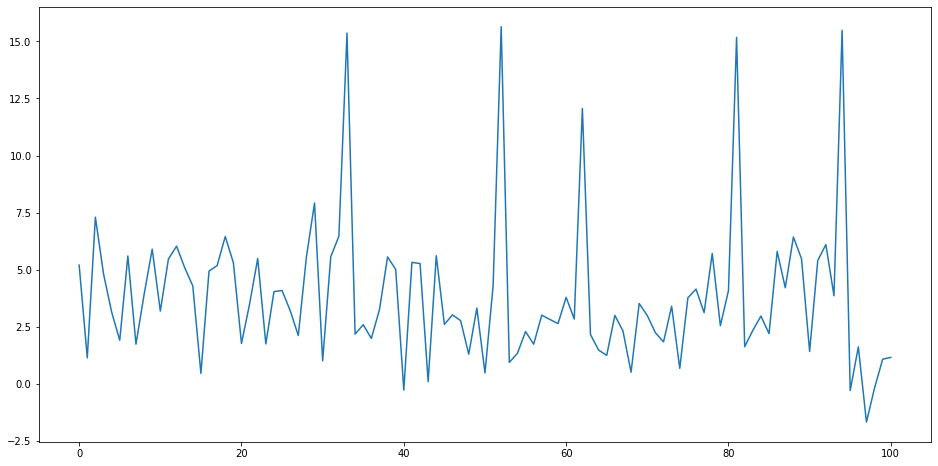

In [ ]:
# load history
#full_hist = np.load("saved/history.npy")
# concat old and new history
#full_hist = np.concatenate((full_hist, np.array(history.history["episode_reward"])))
# save history
#np.save("saved/history.npy", full_hist)
np.save("saved/history8.npy", np.array(history.history["episode_reward"]))

plt.rcParams["figure.figsize"] = (16, 8)
#plt.plot(moving_average(full_hist, 10))
#plt.plot(full_hist)
plt.plot(np.array(history.history["episode_reward"]))
plt.show()